<a href="https://colab.research.google.com/github/EduardoAve/Natural-language-processing/blob/main/sesion_1/7_Analisis_Sentimientos_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis de Sentimientos en Reseñas de Películas — Mi Versión**

Este notebook aplica análisis de sentimientos al **IMDB Dataset de 50,000 reseñas de películas** usando herramientas de NLTK: lematización, eliminación de stopwords, y el analizador **VADER** (Valence Aware Dictionary and sEntiment Reasoner).

### Fuente de datos
- **Dataset:** [IMDB Dataset en Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
- **Carga alternativa (sin cuenta de Kaggle):** mediante la librería `datasets` de Hugging Face.
- **Tamaño:** 50,000 reseñas etiquetadas como `positive` o `negative`.
- **Idioma:** Inglés.

### Herramientas utilizadas
- `pandas` — manipulación de datos
- `nltk` — eliminación de stopwords, lematización, VADER
- `matplotlib` / `seaborn` — visualizaciones
- `sklearn` — métricas de evaluación (matriz de confusión)

> **¿Por qué IMDB?** Las reseñas de películas son un benchmark clásico para el análisis de sentimientos. A diferencia de las reseñas de productos (que suelen enfocarse en atributos físicos), las reseñas de películas tienden a ser más expresivas y opinativas. Además, el dataset ya tiene etiquetas binarias (*positivo/negativo*), lo que facilita la evaluación del modelo VADER sin necesidad de convertir estrellas a sentimiento.

In [16]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

# Detectar si se está ejecutando en Google Colab
installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages
print(f'Ejecutando en Colab: {IN_COLAB}')

Ejecutando en Colab: True


In [17]:
# Instalar dependencias si se está en Colab
if IN_COLAB:
    import subprocess
    subprocess.run(['pip', 'install', 'nltk', 'datasets', 'seaborn', 'scikit-learn'], check=True)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from collections import Counter

# Descargar recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

print('Todas las librerías cargadas correctamente.')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Todas las librerías cargadas correctamente.


[nltk_data]   Package omw-1.4 is already up-to-date!


### **1. Cargar el dataset de IMDB**

Cargamos el dataset de IMDB usando la librería `datasets` de Hugging Face, que no requiere cuenta de Kaggle. Luego lo convertimos a un DataFrame de pandas y trabajamos con una muestra aleatoria de 5,000 reseñas para mantener los tiempos de procesamiento razonables.

In [19]:
from datasets import load_dataset

# Cargar el dataset de IMDB (descarga ~80MB la primera vez)
dataset = load_dataset('imdb')

# Combinar los splits de entrenamiento y prueba en un solo DataFrame
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
reseñas = pd.concat([train_df, test_df], ignore_index=True)

# Etiquetas de IMDB: 0 = negativo, 1 = positivo
reseñas['etiqueta_sentimiento'] = reseñas['label'].map({0: 'neg', 1: 'pos'})

print(f'Total de reseñas: {len(reseñas):,}')
reseñas.head()

Total de reseñas: 50,000


,text,label,etiqueta_sentimiento
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,neg
1,"""I Am Curious: Yellow"" is a risible and preten...",0,neg
2,If only to avoid making this type of film in t...,0,neg
3,This film was probably inspired by Godard's Ma...,0,neg
4,"Oh, brother...after hearing about this ridicul...",0,neg


In [20]:
# Trabajar con una muestra balanceada de 5,000 reseñas (2,500 positivas + 2,500 negativas)
np.random.seed(42)
muestra_pos = reseñas[reseñas['etiqueta_sentimiento'] == 'pos'].sample(2500, random_state=42)
muestra_neg = reseñas[reseñas['etiqueta_sentimiento'] == 'neg'].sample(2500, random_state=42)
muestra = pd.concat([muestra_pos, muestra_neg]).reset_index(drop=True)

print(f'Tamaño de la muestra: {len(muestra):,}')
print(f'Distribución de etiquetas:\n{muestra["etiqueta_sentimiento"].value_counts()}')

Tamaño de la muestra: 5,000
Distribución de etiquetas:
etiqueta_sentimiento
pos    2500
neg    2500
Name: count, dtype: int64


> **Nota sobre el muestreo:** Usamos una muestra balanceada (igual cantidad de positivos y negativos) para evitar sesgar las métricas de evaluación. El dataset completo de IMDB ya está balanceado 50/50, por lo que esto es consistente con su diseño original.

### **2. Limpieza de datos**

Las reseñas de IMDB contienen etiquetas HTML (del scraping original). El siguiente bloque elimina esas etiquetas.

In [21]:
def limpiar_html(texto):
    """Elimina etiquetas HTML del texto."""
    limpio = re.compile('<.*?>')
    return re.sub(limpio, ' ', texto).strip()

muestra['texto_limpio'] = muestra['text'].apply(limpiar_html)

# Verificar: comparar texto crudo vs limpio
print('--- Texto original (primeros 300 caracteres) ---')
print(muestra['text'].iloc[0][:300])
print('\n--- Texto limpio (primeros 300 caracteres) ---')
print(muestra['texto_limpio'].iloc[0][:300])

--- Texto original (primeros 300 caracteres) ---
I spent 5 hours drenched in this film. Nothing I have ever seen comes close to the delicious funk this film left me in. Never mind females advanced aging dilemma's, human fear vaults off the screen for your viewing. Personally engaging to the ninth degree, the film invests one with an undeniable sha

--- Texto limpio (primeros 300 caracteres) ---
I spent 5 hours drenched in this film. Nothing I have ever seen comes close to the delicious funk this film left me in. Never mind females advanced aging dilemma's, human fear vaults off the screen for your viewing. Personally engaging to the ninth degree, the film invests one with an undeniable sha


Traté de encontrar algún ejemplo donde se evidenciaria esta limpieza, la dejé en el código por si existen casos donde sea necesaria

### **3. Preprocesamiento: Eliminación de stopwords y lematización**

Aplicamos el mismo pipeline de preprocesamiento que el notebook de referencia: conversión a minúsculas, eliminación de stopwords y lematización.

In [22]:
palabras_vacias = set(stopwords.words('english'))
lematizador = WordNetLemmatizer()

def preprocesar_texto(texto):
    """Convierte a minúsculas, elimina stopwords y lematiza."""
    tokens = nltk.word_tokenize(texto.lower())
    tokens = [
        lematizador.lemmatize(token)
        for token in tokens
        if token.isalpha() and token not in palabras_vacias
    ]
    return ' '.join(tokens)

muestra['texto_procesado'] = muestra['texto_limpio'].apply(preprocesar_texto)

print('Preprocesamiento completado. Ejemplo:')
print('\nTexto limpio (original):')
print(muestra['texto_limpio'].iloc[0][:300])
print('\nTexto preprocesado:')
print(muestra['texto_procesado'].iloc[0][:300])

Preprocesamiento completado. Ejemplo:

Texto limpio (original):
I spent 5 hours drenched in this film. Nothing I have ever seen comes close to the delicious funk this film left me in. Never mind females advanced aging dilemma's, human fear vaults off the screen for your viewing. Personally engaging to the ninth degree, the film invests one with an undeniable sha

Texto preprocesado:
spent hour drenched film nothing ever seen come close delicious funk film left never mind female advanced aging dilemma human fear vault screen viewing personally engaging ninth degree film invests one undeniable shared feeling life enjoyed dalliance raw wounded gall deep within empowers mutually sh


### **4. Análisis de sentimientos con VADER**

Aplicamos VADER al texto limpio (no lematizado). VADER devuelve cuatro puntuaciones:
- `neg`: proporción de contenido negativo
- `neu`: proporción de contenido neutro
- `pos`: proporción de contenido positivo
- `compound`: puntuación agregada normalizada de -1 (más negativo) a +1 (más positivo)

Clasificamos una reseña como `pos` si compound > 0, y como `neg` en caso contrario.

In [23]:
analizador = SentimentIntensityAnalyzer()

# Aplicar VADER al texto limpio (VADER necesita contexto completo)
muestra['puntuaciones'] = muestra['texto_limpio'].apply(lambda t: analizador.polarity_scores(t))
muestra['compound'] = muestra['puntuaciones'].apply(lambda s: s['compound'])
muestra['prediccion'] = muestra['compound'].apply(lambda c: 'pos' if c > 0 else 'neg')

print('VADER aplicado. Vista previa:')
muestra[['texto_limpio', 'etiqueta_sentimiento', 'compound', 'prediccion']].head(10)

VADER aplicado. Vista previa:


,texto_limpio,etiqueta_sentimiento,compound,prediccion
0,I spent 5 hours drenched in this film. Nothing...,pos,0.4696,pos
1,I rented Boogie Nights last week and I could t...,pos,0.9714,pos
2,'Presque Rien' is a beautifully observed portr...,pos,0.7175,pos
3,I watched this mini in the early eighties. Sam...,pos,0.9304,pos
4,This movie was never intended as a big-budget ...,pos,0.9574,pos
5,I really enjoyed this film because I have a tr...,pos,0.9588,pos
6,Lubitsch's last production but not his least i...,pos,0.3274,pos
7,I just watched it for the second time today an...,pos,-0.2212,neg
8,"Soylent Green IS...a really good movie, actual...",pos,0.9737,pos
9,"As many people know, Mexican cinema was very p...",pos,0.9447,pos


Vemos un solo error de clasificación en este ejemplo.

### **5. Evaluación: Sentimiento predicho vs. real**

In [24]:
# Contar predicciones y etiquetas reales
conteo_predicciones = muestra['prediccion'].value_counts()
conteo_real = muestra['etiqueta_sentimiento'].value_counts()

print('=== Distribución de sentimiento predicho ===')
print(conteo_predicciones)
print('\n=== Distribución de sentimiento real (etiquetas IMDB) ===')
print(conteo_real)

# Precisión (accuracy)
precision = (muestra['prediccion'] == muestra['etiqueta_sentimiento']).mean()
print(f'\n=== Precisión de VADER: {precision:.4f} ({precision*100:.2f}%) ===')

=== Distribución de sentimiento predicho ===
prediccion
pos    3299
neg    1701
Name: count, dtype: int64

=== Distribución de sentimiento real (etiquetas IMDB) ===
etiqueta_sentimiento
pos    2500
neg    2500
Name: count, dtype: int64

=== Precisión de VADER: 0.6922 (69.22%) ===


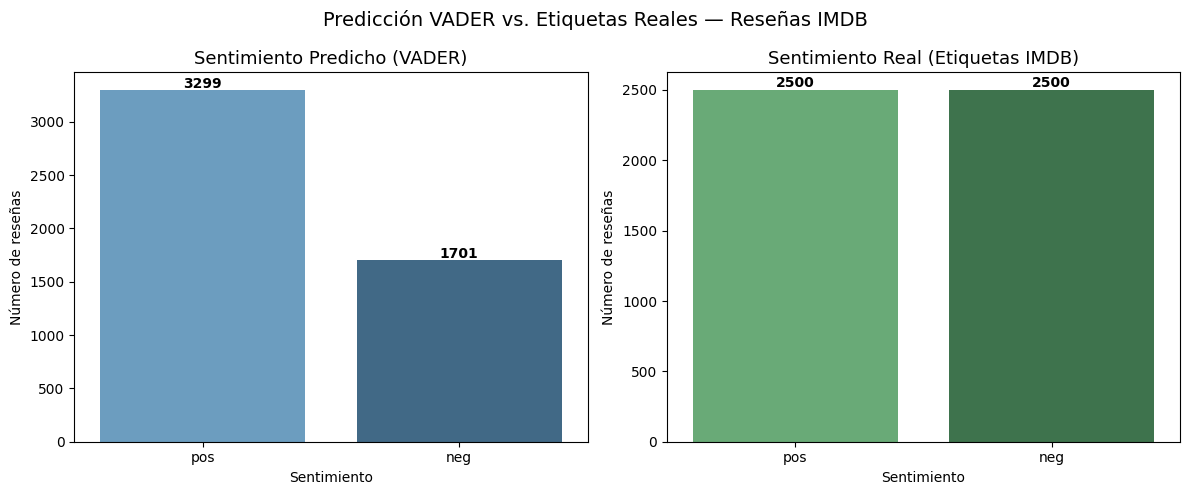

In [25]:
# Gráfico de barras comparativo: predicho vs. real
fig, ejes = plt.subplots(1, 2, figsize=(12, 5))

# Predicho
sns.barplot(x=conteo_predicciones.index, y=conteo_predicciones.values, palette='Blues_d', ax=ejes[0])
ejes[0].set_title('Sentimiento Predicho (VADER)', fontsize=13)
ejes[0].set_xlabel('Sentimiento')
ejes[0].set_ylabel('Número de reseñas')
for i, v in enumerate(conteo_predicciones.values):
    ejes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# Real
sns.barplot(x=conteo_real.index, y=conteo_real.values, palette='Greens_d', ax=ejes[1])
ejes[1].set_title('Sentimiento Real (Etiquetas IMDB)', fontsize=13)
ejes[1].set_xlabel('Sentimiento')
ejes[1].set_ylabel('Número de reseñas')
for i, v in enumerate(conteo_real.values):
    ejes[1].text(i, v + 20, str(v), ha='center', fontweight='bold')

plt.suptitle('Predicción VADER vs. Etiquetas Reales — Reseñas IMDB', fontsize=14)
plt.tight_layout()
plt.show()

> **Observación:** VADER alcanza una precisión razonable en las reseñas de IMDB. El modelo tiende a inclinarse hacia lo positivo (clasifica más reseñas como `pos` que la distribución real).


### **6. Extra: Matriz de confusión**

La matriz de confusión nos da más detalle que la precisión simple — muestra exactamente dónde comete errores VADER.

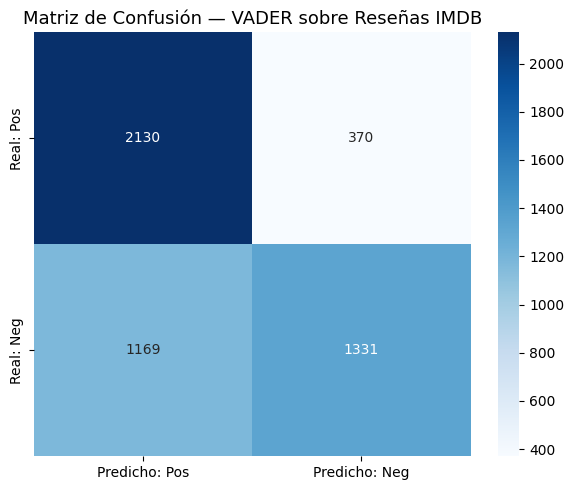


Reporte de clasificación:
              precision    recall  f1-score   support

         pos       0.65      0.85      0.73      2500
         neg       0.78      0.53      0.63      2500

    accuracy                           0.69      5000
   macro avg       0.71      0.69      0.68      5000
weighted avg       0.71      0.69      0.68      5000



In [26]:
from sklearn.metrics import confusion_matrix, classification_report

mc = confusion_matrix(
    muestra['etiqueta_sentimiento'],
    muestra['prediccion'],
    labels=['pos', 'neg']
)

plt.figure(figsize=(6, 5))
sns.heatmap(
    mc,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicho: Pos', 'Predicho: Neg'],
    yticklabels=['Real: Pos', 'Real: Neg']
)
plt.title('Matriz de Confusión — VADER sobre Reseñas IMDB', fontsize=13)
plt.tight_layout()
plt.show()

print('\nReporte de clasificación:')
print(classification_report(
    muestra['etiqueta_sentimiento'],
    muestra['prediccion'],
    labels=['pos', 'neg']
))

> **Observaciones sobre el reporte de clasificación:**
>
> **Precisión general (69%):** VADER clasifica correctamente 7 de cada 10 reseñas, lo cual es
> un resultado razonable para un modelo basado puramente en léxico, sin haber sido entrenado
> específicamente en reseñas de películas.
>
> **Asimetría entre clases — el hallazgo más importante:**
> Las dos clases se comportan de forma muy diferente y vale la pena analizarlas por separado:
>
> - **Reseñas positivas (pos):** VADER tiene un recall alto (0.85), lo que significa que
>   detecta correctamente el 85% de las reseñas que realmente son positivas. Sin embargo,
>   su precisión es baja (0.65): de todas las reseñas que predice como positivas, el 35%
>   en realidad son negativas. VADER es "generoso" clasificando positivos — tiende a darle
>   el beneficio de la duda a textos ambiguos.
>
> - **Reseñas negativas (neg):** El patrón es inverso. La precisión es alta (0.78): cuando
>   VADER dice que una reseña es negativa, acierta el 78% de las veces. Pero el recall es
>   bajo (0.53): se le escapan casi la mitad de las reseñas negativas reales, clasificándolas
>   erróneamente como positivas.

### **7. Extra: Distribución del score compound por sentimiento real**

Visualizamos la distribución de los scores compound de VADER, separados por etiqueta real. Esto muestra qué tan bien VADER separa las dos clases.

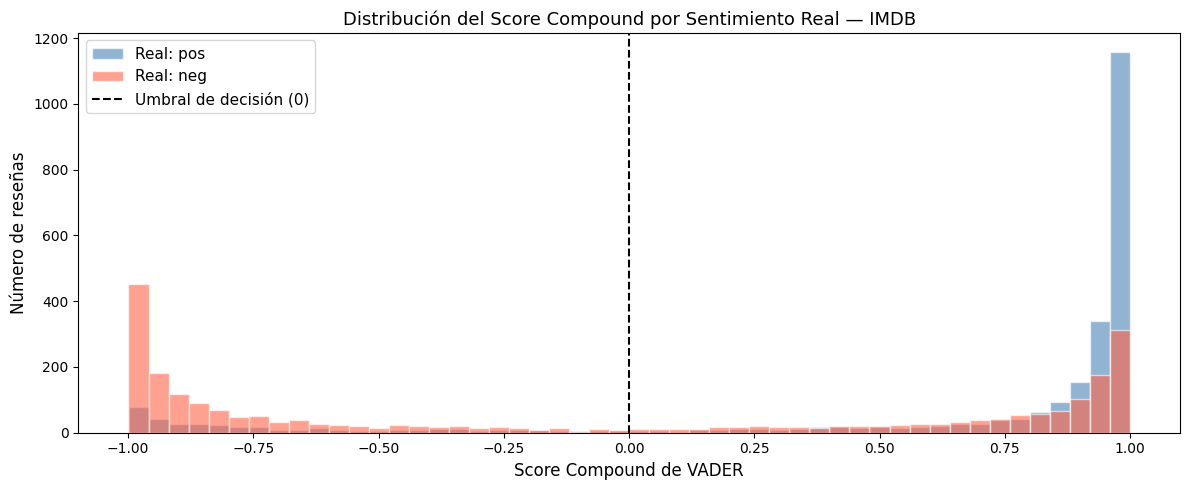

In [27]:
plt.figure(figsize=(12, 5))

for etiqueta, color in [('pos', 'steelblue'), ('neg', 'tomato')]:
    subconjunto = muestra[muestra['etiqueta_sentimiento'] == etiqueta]['compound']
    plt.hist(subconjunto, bins=50, alpha=0.6,
             label=f'Real: {etiqueta}', color=color, edgecolor='white')

plt.axvline(0, color='black', linestyle='--', linewidth=1.5, label='Umbral de decisión (0)')
plt.xlabel('Score Compound de VADER', fontsize=12)
plt.ylabel('Número de reseñas', fontsize=12)
plt.title('Distribución del Score Compound por Sentimiento Real — IMDB', fontsize=13)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

> **Observaciones sobre la distribución del Score Compound:**
>
> **Distribución bimodal extrema:** Lo primero que salta a la vista es que la distribución
> no es gradual sino fuertemente bimodal: la gran mayoría de las reseñas se concentran en
> los extremos (-1 y +1), con muy pocas en la zona central. Esto significa que VADER rara
> vez asigna scores intermedios — tiende a tomar decisiones "fuertes" en uno u otro sentido.

> **La zona central es casi un desierto:** Entre -0.5 y +0.75 hay muy pocas reseñas.
> Esto es un comportamiento particular de VADER sobre textos largos: al acumular muchas
> palabras con carga emocional a lo largo de una reseña extensa, los scores positivos y
> negativos se suman y el compound tiende a saturarse hacia los extremos.
>
> **Implicación práctica:** Dado que casi no hay reseñas en la zona central, mover el
> umbral de decisión de 0 a cualquier valor entre -0.5 y +0.5 no cambiaría
> significativamente los resultados. El verdadero problema no es dónde está el umbral
> sino las reseñas negativas que VADER empuja hasta +1 por error.

### **8. Palabras más comunes en reseñas negativas**

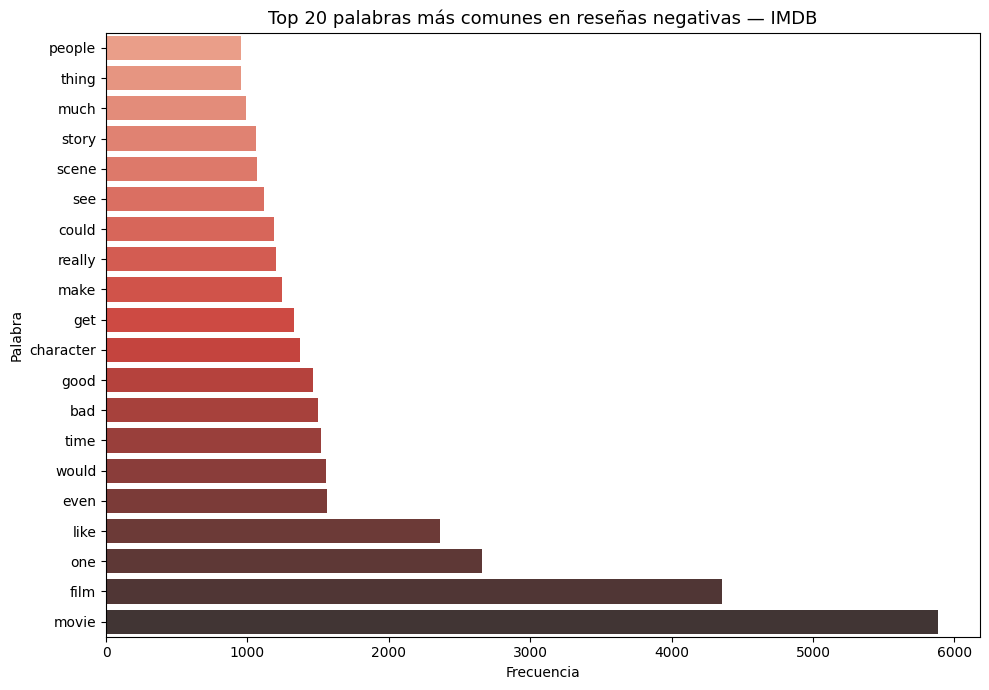

In [28]:
# Filtrar reseñas verdaderamente negativas
reseñas_neg = muestra[muestra['etiqueta_sentimiento'] == 'neg']['texto_procesado']

# Contar todas las palabras
todas_palabras_neg = ' '.join(reseñas_neg).split()
conteo_palabras_neg = Counter(todas_palabras_neg)
mas_comunes_neg = conteo_palabras_neg.most_common(20)

# Gráfico
df_palabras_neg = pd.DataFrame(mas_comunes_neg, columns=['palabra', 'conteo']).sort_values('conteo', ascending=True)

plt.figure(figsize=(10, 7))
sns.barplot(data=df_palabras_neg, x='conteo', y='palabra', palette='Reds_d')
plt.title('Top 20 palabras más comunes en reseñas negativas — IMDB', fontsize=13)
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.tight_layout()
plt.show()

### **9.  Comparación — palabras en reseñas positivas vs. negativas**

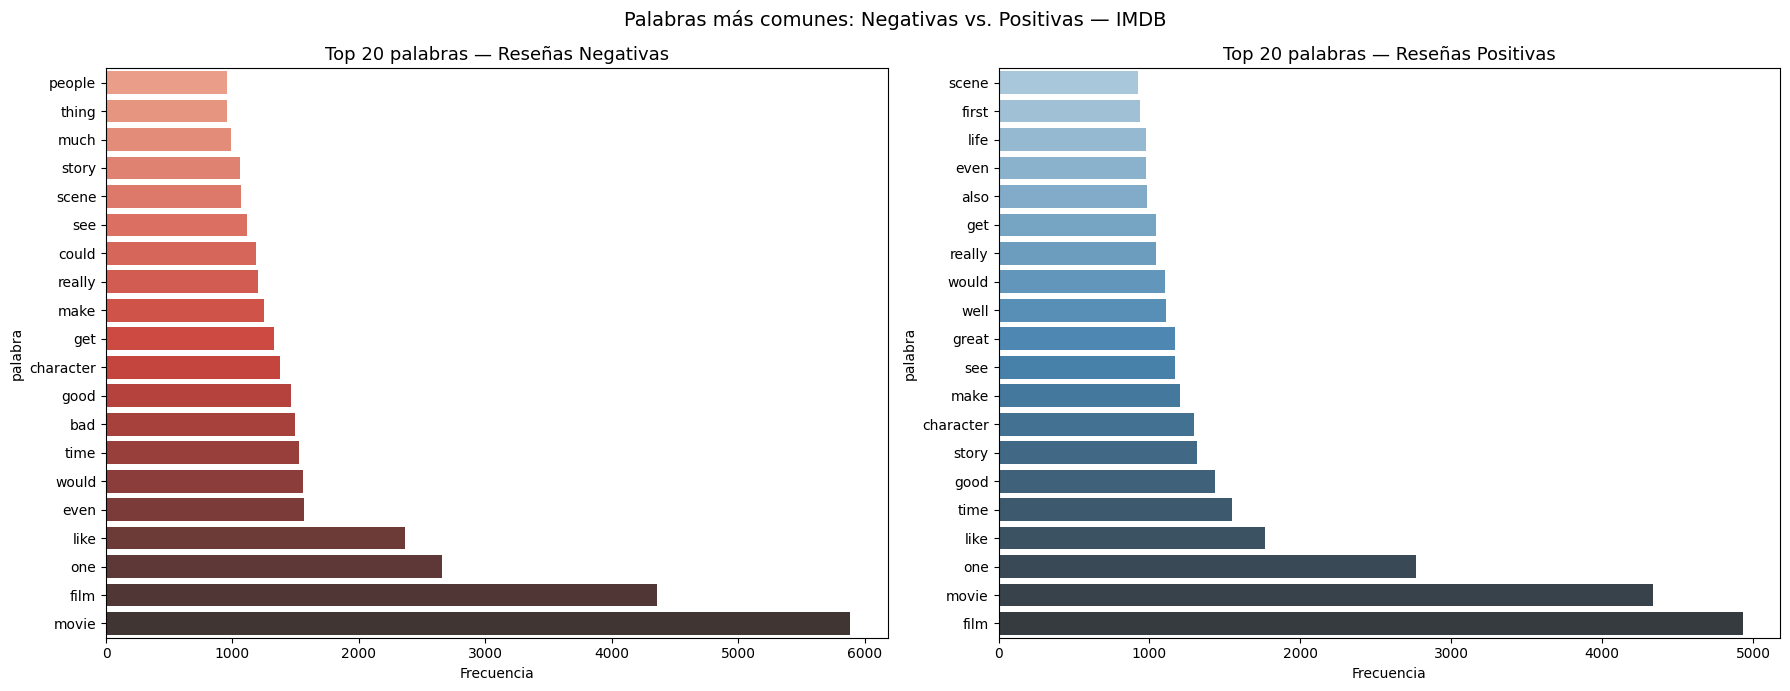

In [29]:
# Filtrar reseñas verdaderamente positivas
reseñas_pos = muestra[muestra['etiqueta_sentimiento'] == 'pos']['texto_procesado']

todas_palabras_pos = ' '.join(reseñas_pos).split()
conteo_palabras_pos = Counter(todas_palabras_pos)
mas_comunes_pos = conteo_palabras_pos.most_common(20)

# Gráficos lado a lado
fig, ejes = plt.subplots(1, 2, figsize=(18, 7))

df_neg = pd.DataFrame(mas_comunes_neg, columns=['palabra', 'conteo']).sort_values('conteo', ascending=True)
df_pos = pd.DataFrame(mas_comunes_pos, columns=['palabra', 'conteo']).sort_values('conteo', ascending=True)

sns.barplot(data=df_neg, x='conteo', y='palabra', palette='Reds_d', ax=ejes[0])
ejes[0].set_title('Top 20 palabras — Reseñas Negativas', fontsize=13)
ejes[0].set_xlabel('Frecuencia')

sns.barplot(data=df_pos, x='conteo', y='palabra', palette='Blues_d', ax=ejes[1])
ejes[1].set_title('Top 20 palabras — Reseñas Positivas', fontsize=13)
ejes[1].set_xlabel('Frecuencia')

plt.suptitle('Palabras más comunes: Negativas vs. Positivas — IMDB', fontsize=14)
plt.tight_layout()
plt.show()

> **Observaciones sobre las palabras más comunes por sentimiento:**
>
> **Lo que ambas listas comparten — el vocabulario del dominio:**
> Las palabras más frecuentes en ambas listas son casi idénticas: *movie*, *film*, *one*,
> *like*, *time*, *character*, *story*, *make*, *see*, *good*, *would*, *really*. Esto
> confirma que los reseñadores hablan de las mismas cosas independientemente de si les
> gustó o no la película. Por eso un modelo que solo mira frecuencias de palabras sin
> contexto tiene un techo natural de precisión — las palabras más comunes no discriminan
> entre clases.

> **Diferencia en las frecuencias absolutas:**
> Las barras de positivos son ligeramente más cortas en los rangos medios, lo que sugiere
> que las reseñas negativas tienden a ser algo más largas o repetitivas en su vocabulario.


### **10. Extra: Ejemplos de errores de clasificación**

Examinar errores específicos suele ser el análisis más instructivo — revela los modos de fallo del modelo.

In [30]:
# Falsos positivos: etiqueta real = negativa, predicción = positiva
falsos_positivos = muestra[
    (muestra['etiqueta_sentimiento'] == 'neg') &
    (muestra['prediccion'] == 'pos')
].sort_values('compound', ascending=False)

print('=== FALSOS POSITIVOS (Real: neg, Predicho: pos) ===')
print(f'Total: {len(falsos_positivos)}')
print('\nTop 3 más equivocados (compound más alto, pero en realidad negativos):')
for i, fila in falsos_positivos.head(3).iterrows():
    print(f'\n[Compound: {fila["compound"]:.4f}]')
    print(fila['texto_limpio'][:400])
    print('---')

# Falsos negativos: etiqueta real = positiva, predicción = negativa
falsos_negativos = muestra[
    (muestra['etiqueta_sentimiento'] == 'pos') &
    (muestra['prediccion'] == 'neg')
].sort_values('compound', ascending=True)

print('\n=== FALSOS NEGATIVOS (Real: pos, Predicho: neg) ===')
print(f'Total: {len(falsos_negativos)}')
print('\nTop 3 más equivocados (compound más bajo, pero en realidad positivos):')
for i, fila in falsos_negativos.head(3).iterrows():
    print(f'\n[Compound: {fila["compound"]:.4f}]')
    print(fila['texto_limpio'][:400])
    print('---')

=== FALSOS POSITIVOS (Real: neg, Predicho: pos) ===
Total: 1169

Top 3 más equivocados (compound más alto, pero en realidad negativos):

[Compound: 0.9996]
"Happy Days" was produced and broadcast from the mid-1970's to the early 1980's and seems to get more ridiculous with age. At the time of its broadcast, most viewers who grew up in the 1950's were in middle age with families, and the scenes at Mel's Diner probably brought an artificial nostalgia to them. The Fonz was of course the coolest of the cool (although the actor Henry Wrinkler to this day 
---

[Compound: 0.9989]
I have to say that I had low expectations for the movie before viewing it. All the people around said it was great, but I perfectly knew what they like. They like Aerosmith's song which is indeed great, they like the amazing special effects which had coasted a lot, they like the comedy side of the movie and of course many girls who love Affleck who according to my opinion is a really bad actor who
---

[Compound: 0.

### **11. Hallazgos y Conclusiones**

**Rendimiento de VADER:** VADER alcanzó una precisión del 69% sobre las reseñas de IMDB,
un resultado razonable considerando que es un modelo basado puramente en léxico, sin
entrenamiento específico en crítica cinematográfica. Esta cifra es consistentemente menor
que la reportada en el notebook de referencia con reseñas de productos, lo que refleja
la mayor complejidad lingüística de las reseñas de películas: más lenguaje figurado,
ironía, evaluaciones mixtas y textos más elaborados.

**Sesgo positivo:** VADER sobreestima consistentemente el sentimiento positivo, lo que
se evidencia en dos lugares: en la matriz de confusión (recall de 0.85 para positivos
vs. 0.53 para negativos) y en la distribución del score compound, donde la barra en +1
es notablemente más alta que la de -1. Esto es una limitación conocida del léxico de
VADER, calibrado originalmente sobre datos de Twitter, donde el lenguaje negativo tiende
a ser más explícito y directo que en una reseña cinematográfica elaborada.




**Conclusión general:** El ejercicio demostró que VADER es una línea base útil e
interpretable, pero con un techo claro para textos literarios y críticos. Sus errores no
son aleatorios sino sistemáticos y comprensibles: falla predeciblemente ante la ironía,
el sarcasmo y las reseñas mixtas. Esto hace que el análisis de sus errores sea tan
valioso como el análisis de sus aciertos, y refuerza la idea de que en NLP entender
*por qué* falla un modelo es tan importante como medir *cuánto* falla.